In [ ]:
import pandas as pd
import numpy as np
import quantiacsToolbox
from keras.models import Sequential
#from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
import technical_analysis_functions as taf
from sklearn.preprocessing import MinMaxScalar

import math
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import LSTM
from keras.layers import Activation, Dense
from keras.layers import Dropout
from keras import optimizers

In [ ]:
# https://www.tensorflow.org/tutorials/structured_data/time_series
# https://github.com/peter001zhang/q_trading

# 1. Reading Data

In [ ]:
markets = ['F_AD','F_BO','F_BP','F_C','F_CC','F_CD','F_CL',
        'F_CT','F_DX','F_EC','F_ES','F_FC','F_FV','F_GC','F_F',
        'F_HG','F_HO','F_JY','F_KC','F_LB','F_LC','F_LN','F_MD',
        'F_MP','F_NG','F_NQ','F_NR','F_O','F_OJ','F_PA','F_PL',
        'F_RB','F_RU','F_S','F_SB','F_SF','F_SI','F_SM','F_TU',
        'F_TY','F_US','F_W','F_XX','F_YM','F_AX','F_CA','F_DT',
        'F_UB','F_UZ','F_GS','F_LX','F_DL','F_ZQ','F_VX','F_SS',
        'F_AE','F_BG','F_BC','F_LU','F_DM','F_AH','F_CF','F_DZ',
        'F_FB','F_FL','F_FM','F_FP','F_FY','F_GX','F_HP','F_LR',
        'F_LQ','F_ND','F_NY','F_PQ','F_RR','F_RF','F_RP','F_RY',
        'F_SH','F_SX','F_TR','F_EB','F_VF','F_VT','F_VW','F_GD']

In [3]:
curr_futures = 'F_AD'
filename = '~/Desktop/Team_Ravioli_Timeseries/tickerData/'+curr_futures+'.txt'

In [4]:
data = pd.read_csv(filename, sep = ",", header = None)
data.columns = [i.strip() for i in data.iloc[0]]
data = data[1:-1]
data = data.apply(pd.to_numeric)
data= data.reset_index()

In [5]:
data.head()

,index,DATE,OPEN,HIGH,LOW,CLOSE,VOL,OI,P,R,RINFO
0,1,19900102,77300.0,77400.0,77020.0,77020.0,125,2559,0,0,0.0
1,2,19900103,76890.0,77030.0,76700.0,76740.0,1495,3215,0,0,0.0
2,3,19900104,77080.0,77610.0,77000.0,77490.0,932,3122,0,0,0.0
3,4,19900105,77050.0,77280.0,76980.0,76980.0,272,2542,0,0,0.0
4,5,19900108,77280.0,77300.0,77090.0,77200.0,177,2430,0,0,0.0


In [ ]:
min(data['DATE'])

In [ ]:
data[data['DATE'] == 20180119]

# 2. Preprocess Data

## Creating Technical Indicators

In [6]:
# Create 7 and 21 days Moving Average
data['ma7'] = data['CLOSE'].rolling(window=7).mean()
data['ma21'] = data['CLOSE'].rolling(window=21).mean()
    
# Create MACD
data['26ema'] = data['CLOSE'].ewm(span = 26).mean()
data['12ema'] = data['CLOSE'].ewm(span = 12).mean()
data['MACD'] = (data['12ema']-data['26ema'])

# Create Bollinger Bands
data['20sd'] = data['CLOSE'].rolling(window=20).std()
data['ma20'] = data['CLOSE'].rolling(window=20).mean()
data['upper_band'] = data['ma20'] + (data['20sd']*2)
data['lower_band'] = data['ma20'] - (data['20sd']*2)
    
# Create Exponential moving average
# exponential weighted function with decay term = 0.5, 𝛼=1/(1+𝑐𝑜𝑚)
data['ema'] = data['CLOSE'].ewm(com=0.5).mean()
    
# Create Momentum
data['momentum'] = data['CLOSE']-1

In [ ]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['CLOSE'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')

    plt.legend()
    plt.show()

In [ ]:
plot_technical_indicators(data, 400)

In [ ]:
# normalise the input
def normalise(input):
    min_max_scalar = MinMaxScaler()
    return minmax_scaler.fit_transform(input)

## Incorporate ARIMA feature

# 3. Modelling

## Reshape data

In [9]:
data_X = data.drop(['index', 'DATE', 'CLOSE','OI', 'P', 'R', 'RINFO'], axis = 1)
data_Y = data[['CLOSE']]

In [10]:
def build_timeseries(X_data, Y_data, time_steps):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = X_data.shape[0] - time_steps
    dim_1 = X_data.shape[1]
    x = np.zeros((dim_0, time_steps, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0):
        x[i] = X_data[i:time_steps+i]
        y[i] = Y_data[time_steps+i]
    return x, y

In [11]:
# shape for input X = [samples, timesteps, features]
train_X, test_X = np.array(data_X[21:7055]), np.array(data_X[7026:-1])
train_Y, test_Y = np.array(data_Y[22:7056]), np.array(data_Y[7027:len(data_Y)])

train_X, train_y = build_timeseries(train_X, train_Y, 30)
test_X, test_y = build_timeseries(test_X, test_Y, 30)

## Model Architecture

In [22]:
# default learning rate for adam is 0.01
def LSTM_model(inputs, activ_func="relu", dropout=0.10, loss="mae", optimizer="adam"):
    model = Sequential()
    
    model.add(LSTM(64, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=128))
    model.add(Dense(units=1))
    model.add(Activation(activ_func))
    
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [24]:
model = LSTM_model(train_X)
history = model.fit(train_X, train_y, 
                    epochs=200, 
                    batch_size=256,
                    verbose=2, 
                    shuffle=False)

Epoch 1/500
 - 4s - loss: 76225.3951
Epoch 2/500
 - 2s - loss: 76215.7283
Epoch 3/500
 - 1s - loss: 76200.0664
Epoch 4/500
 - 1s - loss: 76176.4203
Epoch 5/500
 - 2s - loss: 76143.2496
Epoch 6/500
 - 1s - loss: 76097.9122
Epoch 7/500
 - 1s - loss: 76043.4275
Epoch 8/500
 - 1s - loss: 75979.0254
Epoch 9/500
 - 1s - loss: 75904.4285
Epoch 10/500
 - 1s - loss: 75820.8362
Epoch 11/500
 - 1s - loss: 75726.5247
Epoch 12/500
 - 1s - loss: 75623.9970
Epoch 13/500
 - 2s - loss: 75510.2356
Epoch 14/500
 - 2s - loss: 75388.2609
Epoch 15/500
 - 2s - loss: 75256.4318
Epoch 16/500
 - 2s - loss: 75114.5048
Epoch 17/500
 - 1s - loss: 74966.3916
Epoch 18/500
 - 1s - loss: 74805.3295
Epoch 19/500
 - 1s - loss: 74639.3339
Epoch 20/500
 - 1s - loss: 74464.4111
Epoch 21/500
 - 1s - loss: 74276.7499
Epoch 22/500
 - 1s - loss: 74082.7577
Epoch 23/500
 - 1s - loss: 73876.2356
Epoch 24/500
 - 1s - loss: 73672.5690
Epoch 25/500
 - 1s - loss: 73445.5895
Epoch 26/500
 - 1s - loss: 73219.6209
Epoch 27/500
 - 1s - 

Epoch 214/500
 - 1s - loss: 10369.2218
Epoch 215/500
 - 1s - loss: 10359.5187
Epoch 216/500
 - 1s - loss: 10378.8059
Epoch 217/500
 - 1s - loss: 10279.1652
Epoch 218/500
 - 1s - loss: 10285.4080
Epoch 219/500
 - 1s - loss: 10329.3446
Epoch 220/500
 - 1s - loss: 10319.1147
Epoch 221/500
 - 1s - loss: 10409.6138
Epoch 222/500
 - 1s - loss: 10397.6930
Epoch 223/500
 - 1s - loss: 10360.5401
Epoch 224/500
 - 1s - loss: 10348.8566
Epoch 225/500
 - 2s - loss: 10384.0431
Epoch 226/500
 - 2s - loss: 10374.2619
Epoch 227/500
 - 1s - loss: 10232.5823
Epoch 228/500
 - 1s - loss: 10312.4286
Epoch 229/500
 - 1s - loss: 10314.8939
Epoch 230/500
 - 1s - loss: 10216.7154
Epoch 231/500
 - 1s - loss: 10324.5476
Epoch 232/500
 - 1s - loss: 10380.8992
Epoch 233/500
 - 1s - loss: 10317.2904
Epoch 234/500
 - 1s - loss: 10334.0892
Epoch 235/500
 - 1s - loss: 10394.1656
Epoch 236/500
 - 1s - loss: 10271.1395
Epoch 237/500
 - 1s - loss: 10341.1497
Epoch 238/500
 - 1s - loss: 10274.9480
Epoch 239/500
 - 1s - los

 - 1s - loss: 10050.1607
Epoch 425/500
 - 1s - loss: 10115.7963
Epoch 426/500
 - 1s - loss: 10157.4152
Epoch 427/500
 - 1s - loss: 10111.8615
Epoch 428/500
 - 1s - loss: 10122.4689
Epoch 429/500
 - 1s - loss: 10200.2671
Epoch 430/500
 - 1s - loss: 10221.5319
Epoch 431/500
 - 1s - loss: 10114.1983
Epoch 432/500
 - 1s - loss: 10143.1573
Epoch 433/500
 - 1s - loss: 10143.0914
Epoch 434/500
 - 1s - loss: 10136.1399
Epoch 435/500
 - 1s - loss: 10178.6266
Epoch 436/500
 - 1s - loss: 10062.9948
Epoch 437/500
 - 1s - loss: 10151.1948
Epoch 438/500
 - 1s - loss: 10138.0445
Epoch 439/500
 - 1s - loss: 10137.7374
Epoch 440/500
 - 1s - loss: 9980.7355
Epoch 441/500
 - 1s - loss: 10128.5846
Epoch 442/500
 - 1s - loss: 10075.6705
Epoch 443/500
 - 1s - loss: 10045.8035
Epoch 444/500
 - 1s - loss: 10128.5634
Epoch 445/500
 - 1s - loss: 10107.5899
Epoch 446/500
 - 1s - loss: 10109.5216
Epoch 447/500
 - 1s - loss: 10087.2913
Epoch 448/500
 - 1s - loss: 10179.8126
Epoch 449/500
 - 1s - loss: 10142.1069
E

In [26]:
predict_y = model.predict(test_X)

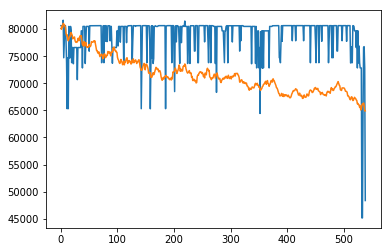

In [27]:
plt.plot(predict_y)
plt.plot(test_y)

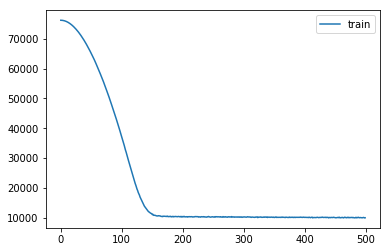

In [29]:
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Comparing with ARIMA output

In [35]:
from pmdarima import auto_arima

In [44]:
log_data = np.log(data['CLOSE'])
train, test = log_data[0:7055], log_data[7026:-1]

In [48]:
train_model = auto_arima(train, error_action='ignore', suppress_warnings=True)#arima
train_model.fit(train)
predicted = train_model.predict(n_periods=30)

In [ ]:
predict_list = []
order_list = []

for i in range (0, 30):
    train_model = auto_arima(log_data[0:7055+i],error_action='ignore', suppress_warnings=True, seasonal = True, m = 12)#arima
    train_model.fit(log_data[0:7055+i])
    predicted = train_model.predict(n_periods=1)
    
    predict_list.append(predicted)
    order_list.append(train_model.order)

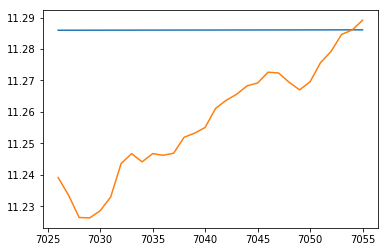

In [54]:
plt.plot(log_data.index[7026:7056], predicted)
plt.plot(log_data.index[7026:7056], log_data[7026:7056])